In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
files_list = []
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    files_list.append(file_name[41:])
    file_name = 'data1/' + file_name[41:]

    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# the 2 cells below shouldn't be useful anymore
# for verification purposes later, count the nr of characters for each content
#sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
#sources['file_len'].sum()

In [0]:

# variable containing all documents together
#all_texts = ''
#for i in range(len(sources)):
#all_texts += sources['file_content'][i]
# check length
#len(all_texts)

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to removes all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
sources['doc_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 3 )])

In [0]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')

In [0]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
# import spacy
# from spacy.lang.it.stop_words import STOP_WORDS
# spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['doc_prep_nostop'] = sources['doc_prep'].apply(lambda x: [w for w in x if not w in ital_stopwords])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['doc_stemmed'] = sources['doc_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['doc_lemmatized'] = sources['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['doc_lemmatized']

# 2. Topics with LDA

In [0]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [0]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [0]:
# sort descending
# words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 8

### 2.2.1 LDA with Gensim

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [0]:
ldagensim.print_topics()

[(0,
  '0.006*"italiano" + 0.004*"stare" + 0.004*"italia" + 0.003*"anno" + 0.003*"cardinale" + 0.003*"tutto" + 0.003*"altro" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"dire"'),
 (1,
  '0.006*"italiano" + 0.003*"roma" + 0.003*"stare" + 0.003*"dispaccio" + 0.003*"anno" + 0.003*"dire" + 0.003*"nuovo" + 0.003*"grande" + 0.003*"telegrafico" + 0.003*"italia"'),
 (2,
  '0.005*"italiano" + 0.004*"stare" + 0.004*"fare" + 0.004*"altro" + 0.003*"primo" + 0.003*"italia" + 0.003*"nuovo" + 0.003*"roma" + 0.003*"potere" + 0.003*"tutto"'),
 (3,
  '0.009*"italiano" + 0.004*"stare" + 0.004*"fare" + 0.004*"altro" + 0.004*"italia" + 0.003*"daily" + 0.003*"anno" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"potere"'),
 (4,
  '0.006*"italiano" + 0.005*"stare" + 0.004*"altro" + 0.003*"dispaccio" + 0.003*"potere" + 0.003*"roma" + 0.003*"italia" + 0.003*"venire" + 0.003*"fare" + 0.003*"nuovo"'),
 (5,
  '0.008*"italiano" + 0.004*"potere" + 0.004*"telegrafico" + 0.003*"italia" + 0.003*"dispaccio" + 0.003*"stare" 

### 2.2.2 Visualize topics

In [0]:
# pyLDAvis installation
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 6 topics
%%capture
numtopics = 8
selected_model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus, id2word)

In [0]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.000920 -0.005288       1        1  25.000137
0     -0.002031  0.000041       2        1  21.243835
3     -0.000931  0.001506       3        1  17.794895
4     -0.002516  0.002917       4        1  10.805663
2     -0.001658 -0.000692       5        1   9.264287
5     -0.000150  0.001955       6        1   8.457166
6      0.001327 -0.001104       7        1   4.886717
1      0.006879  0.000665       8        1   2.547299, topic_info=            Term         Freq        Total Category  logprob  loglift
473     italiano  1002.000000  1002.000000  Default  30.0000  30.0000
944        stare   565.000000   565.000000  Default  29.0000  29.0000
973  telegrafico   372.000000   372.000000  Default  28.0000  28.0000
36         altro   446.000000   446.000000  Default  27.0000  27.0000
51          anno   447.000000   447.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
296         dopo     5.776805   251.242935   Topic8  -6.4640  -0.1024
412    governare     5.768344   255.668732   Topic8  -6.4655  -0.1214
670      partire     6.127980   312.930084   Topic8  -6.4050  -0.2630
280    dispaccio     7.051901   483.685974   Topic8  -6.2646  -0.5580
271         dire     6.435649   426.487640   Topic8  -6.3560  -0.5236

[740 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
22        1  0.225966  agire
22        2  0.215205  agire
22        3  0.182925  agire
22        4  0.107603  agire
22        5  0.118363  agire
...     ...       ...    ...
1087      4  0.091806  zione
1087      5  0.128529  zione
1087      6  0.082626  zione
1087      7  0.064264  zione
1087      8  0.036722  zione

[2091 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 4, 5, 3, 6, 7, 2])

### 2.2.3 LDA with Mallet

In [0]:
%%capture
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [0]:
ldamallet.print_topics()

[(0,
  '0.018*"italiano" + 0.013*"roma" + 0.011*"italia" + 0.010*"dispaccio" + 0.010*"giornale" + 0.009*"telegrafico" + 0.009*"visitare" + 0.008*"maggio" + 0.008*"presidente" + 0.007*"daily"'),
 (1,
  '0.019*"italiano" + 0.010*"dire" + 0.009*"fare" + 0.008*"potere" + 0.008*"anno" + 0.007*"altro" + 0.007*"molto" + 0.007*"roma" + 0.007*"italia" + 0.007*"tale"'),
 (2,
  '0.009*"città" + 0.008*"ieri" + 0.007*"mentire" + 0.007*"dopo" + 0.006*"venire" + 0.006*"ebreo" + 0.006*"molto" + 0.006*"fatto" + 0.005*"scrivere" + 0.005*"tangere"'),
 (3,
  '0.024*"cardinale" + 0.019*"papa" + 0.010*"chiesa" + 0.010*"roma" + 0.009*"dopo" + 0.009*"pontefice" + 0.009*"vaticano" + 0.008*"leone" + 0.008*"xiii" + 0.008*"nome"'),
 (4,
  '0.013*"dispaccio" + 0.011*"stare" + 0.010*"nuovo" + 0.010*"governare" + 0.009*"telegrafico" + 0.008*"italiano" + 0.008*"dire" + 0.008*"parigi" + 0.007*"partire" + 0.006*"venire"'),
 (5,
  '0.015*"grande" + 0.014*"primo" + 0.013*"giorno" + 0.011*"fare" + 0.009*"anno" + 0.009*"eg

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim

In [0]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.2525277632176363


### 2.3.1 Coherence score LDA Mallet


In [0]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.3493078147319634


## 2.4 Coherence and number of topics

### 2.4.1 LDA Gensim

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 2  has Coherence Value of 0.2501
Num Topics = 3  has Coherence Value of 0.2498
Num Topics = 4  has Coherence Value of 0.2491
Num Topics = 5  has Coherence Value of 0.2572
Num Topics = 6  has Coherence Value of 0.2514
Num Topics = 7  has Coherence Value of 0.2536
Num Topics = 8  has Coherence Value of 0.2532
Num Topics = 9  has Coherence Value of 0.2514
Num Topics = 10  has Coherence Value of 0.2563
Num Topics = 11  has Coherence Value of 0.2545
Num Topics = 12  has Coherence Value of 0.2493
Num Topics = 13  has Coherence Value of 0.2506
Num Topics = 14  has Coherence Value of 0.2534
Num Topics = 15  has Coherence Value of 0.2626
Num Topics = 16  has Coherence Value of 0.2482
Num Topics = 17  has Coherence Value of 0.2508
Num Topics = 18  has Coherence Value of 0.2589
Num Topics = 19  has Coherence Value of 0.2539


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

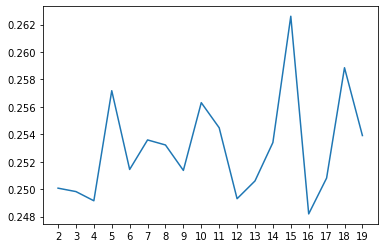

In [0]:
plt.plot(topics_nr, coherence_values_gensim)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 8
%%capture
numtopics = 8
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [0]:
model.print_topics()

[(0,
  '0.007*"italiano" + 0.004*"stare" + 0.004*"italia" + 0.003*"dispaccio" + 0.003*"fare" + 0.003*"altro" + 0.003*"grande" + 0.003*"roma" + 0.003*"potere" + 0.003*"telegrafico"'),
 (1,
  '0.007*"italiano" + 0.004*"stare" + 0.004*"fare" + 0.004*"altro" + 0.003*"potere" + 0.003*"grande" + 0.003*"dire" + 0.003*"italia" + 0.003*"roma" + 0.003*"dispaccio"'),
 (2,
  '0.008*"italiano" + 0.005*"italia" + 0.004*"altro" + 0.004*"fare" + 0.004*"giornale" + 0.004*"stare" + 0.003*"tutto" + 0.003*"nuovo" + 0.003*"primo" + 0.003*"giorno"'),
 (3,
  '0.008*"italiano" + 0.004*"stare" + 0.004*"anno" + 0.003*"fare" + 0.003*"roma" + 0.003*"potere" + 0.003*"dispaccio" + 0.003*"primo" + 0.003*"italia" + 0.003*"telegrafico"'),
 (4,
  '0.005*"italiano" + 0.004*"roma" + 0.004*"stare" + 0.003*"potere" + 0.003*"dire" + 0.003*"dispaccio" + 0.003*"anno" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"primo"'),
 (5,
  '0.006*"italiano" + 0.003*"anno" + 0.003*"dire" + 0.003*"stare" + 0.003*"dispaccio" + 0.003*"tel

### 2.4.2 LDA Mallet

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_mallet = []
for num_topics in range(2, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_mallet.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_mallet[i],4))

Num Topics = 2  has Coherence Value of 0.3036
Num Topics = 3  has Coherence Value of 0.2915
Num Topics = 4  has Coherence Value of 0.319
Num Topics = 5  has Coherence Value of 0.313
Num Topics = 6  has Coherence Value of 0.3432
Num Topics = 7  has Coherence Value of 0.3556
Num Topics = 8  has Coherence Value of 0.3516
Num Topics = 9  has Coherence Value of 0.3558
Num Topics = 10  has Coherence Value of 0.3524
Num Topics = 11  has Coherence Value of 0.3319
Num Topics = 12  has Coherence Value of 0.35
Num Topics = 13  has Coherence Value of 0.3639
Num Topics = 14  has Coherence Value of 0.3497
Num Topics = 15  has Coherence Value of 0.3665
Num Topics = 16  has Coherence Value of 0.3448
Num Topics = 17  has Coherence Value of 0.354
Num Topics = 18  has Coherence Value of 0.3628
Num Topics = 19  has Coherence Value of 0.3424


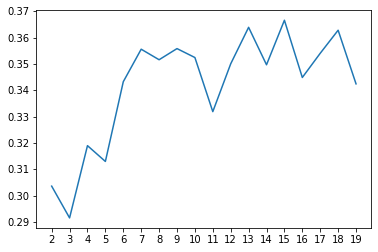

In [0]:
plt.plot(topics_nr, coherence_values_mallet)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 8
%%capture
numtopics = 8
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [0]:
model.print_topics()

[(0,
  '0.014*"giorno" + 0.009*"italiano" + 0.009*"maggio" + 0.008*"nome" + 0.008*"gran" + 0.007*"giornale" + 0.007*"popolare" + 0.007*"perchè" + 0.006*"morto" + 0.006*"italian"'),
 (1,
  '0.017*"italiano" + 0.012*"stare" + 0.011*"fare" + 0.010*"potere" + 0.010*"paese" + 0.009*"altro" + 0.007*"dovere" + 0.007*"operare" + 0.007*"anno" + 0.007*"essere"'),
 (2,
  '0.019*"italiano" + 0.011*"americano" + 0.010*"stato" + 0.009*"dispaccio" + 0.008*"unito" + 0.008*"generale" + 0.007*"daily" + 0.007*"giugno" + 0.007*"york" + 0.006*"avere"'),
 (3,
  '0.011*"dispaccio" + 0.009*"anno" + 0.009*"telegrafico" + 0.009*"partire" + 0.008*"nuovo" + 0.008*"milione" + 0.007*"gran" + 0.007*"mila" + 0.007*"italia" + 0.007*"primo"'),
 (4,
  '0.012*"stare" + 0.012*"potere" + 0.011*"leggere" + 0.010*"tutto" + 0.009*"lavorare" + 0.008*"sotto" + 0.007*"quando" + 0.007*"nuovo" + 0.006*"cosa" + 0.005*"senza"'),
 (5,
  '0.022*"cardinale" + 0.018*"papa" + 0.011*"roma" + 0.009*"chiesa" + 0.009*"nuovo" + 0.008*"pontefi

# Topic distribution

## 3.1. Gensim

### 3.1.1. Distribution per topic and per document

In [0]:
%%capture
numtopics = 8
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)

In [0]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [0]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
distribution_gensim.index.name = 'document'

In [0]:
# add file names
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
document,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000078,0.000078,0.000078,0.000078,0.686621,0.000078,0.312908,0.000078
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.246286,0.000070,0.000070,0.000070,0.000070,0.054853,0.698513,0.000070
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.999351,0.000093
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.000100,0.000100,0.000100,0.000100,0.572631,0.000100,0.426770,0.000100
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000150,0.998949,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150
...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.997977
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.000086,0.128302,0.000086,0.024126,0.810042,0.000086,0.037187,0.000086
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000076,0.002932,0.000076,0.000076,0.000076,0.000076,0.996610,0.000076


### 3.1.2. Distribution per topic for the whole corpus

In [0]:
sources['doc_length'] = sources['doc_lemmatized'].apply(lambda x: len(x))

In [0]:
topic_frequency = distribution_gensim.mul(sources['doc_length'], axis=0).sum()

In [0]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [0]:
topic_proportion

topic6    65.626495
topic4    11.417770
topic0     7.381421
topic1     5.679488
topic3     2.998557
topic7     2.680700
topic5     2.383458
topic2     1.832112
dtype: float64

In [0]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [0]:
distribution_df_gensim.index.name = "topics"

In [0]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

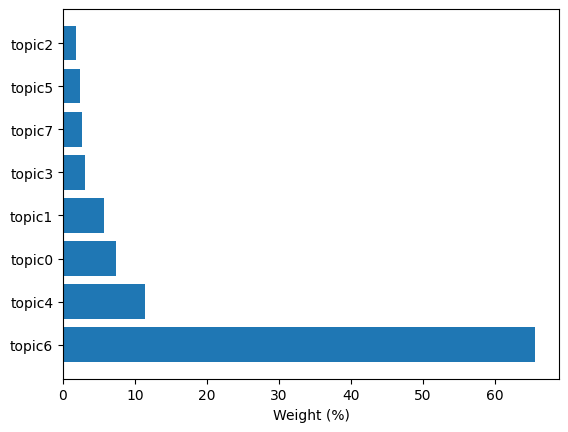

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

##3.2 Mallet

### 3.2.1 Distribution per topic and per document

In [0]:
%%capture
#create variable to retranslate model to Gensim, to be able to compute distribution at a later stage
numtopics = 8
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)
ldamallet = model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)
ldamallet_to_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [0]:
doc_topic_weights_mallet = ldamallet_to_gensim.inference(corpus)[0]

In [0]:
doc_topic_dists_mallet = doc_topic_weights_mallet / doc_topic_weights_mallet.sum(axis=1)[:, None]

In [0]:
distribution_mallet = pd.DataFrame(doc_topic_dists_mallet,columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
distribution_mallet.index.name = 'document'

In [0]:
# add file names
distribution_mallet_wfiles = distribution_mallet.copy()
distribution_mallet_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_mallet_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
document,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.093817,0.059732,0.151320,0.124458,0.049916,0.298955,0.058024,0.163778
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.106168,0.092802,0.060745,0.080671,0.042847,0.229950,0.067799,0.319018
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.210531,0.144300,0.174361,0.048388,0.031279,0.207593,0.028640,0.154908
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.096642,0.101234,0.125268,0.063077,0.064394,0.391957,0.034039,0.123390
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.294959,0.015236,0.209476,0.046550,0.028719,0.114869,0.182340,0.107851
...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.255443,0.051926,0.056623,0.069092,0.409630,0.097537,0.027841,0.031907
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.145809,0.051360,0.066069,0.068417,0.215523,0.103669,0.039587,0.309566
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.223043,0.088606,0.125114,0.064388,0.222572,0.053591,0.063675,0.159011


### 3.2.2. Distribution per topic for the whole corpus

In [0]:
topic_frequency_mallet = distribution_mallet.mul(sources['doc_length'], axis=0).sum()

In [0]:
topic_proportion_mallet = (topic_frequency_mallet / topic_frequency_mallet.sum()*100).sort_values(ascending=False)

In [0]:
distribution_df_mallet = pd.DataFrame(topic_proportion_mallet, columns=['weight'])

In [0]:
distribution_df_mallet.index.name = "topics"

In [0]:
topics_mallet = distribution_df_mallet.index.array

Text(0.5, 0, 'Weight (%)')

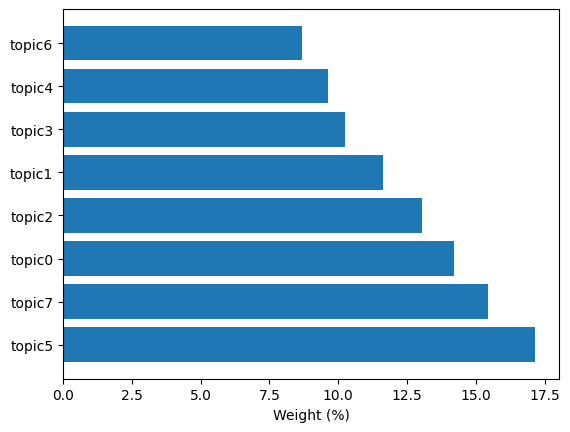

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics_mallet, distribution_df_mallet['weight'], align='center')
ax.set_xlabel('Weight (%)')

# Topics weight over time: Gensim

## 4.1 Aggregate document weights

In [0]:
# grouping data per month

In [0]:
import re

In [0]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [0]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [0]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [0]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [0]:
# group by year and month 
distribution_month = gensim_groupby.groupby(['year','month']).mean().reset_index()

In [0]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,1903,04,0.061639,0.000085,0.000085,0.000085,0.314854,0.013781,0.609386,0.000085
1,1903,05,0.021533,0.101374,0.046933,0.029504,0.114697,0.021301,0.663595,0.001063
2,1903,06,0.106011,0.039765,0.003366,0.054424,0.087749,0.002123,0.672805,0.033757
3,1903,07,0.105780,0.062493,0.024258,0.008924,0.106899,0.071502,0.546053,0.074090
4,1903,08,0.000117,0.014723,0.001163,0.113767,0.217294,0.092664,0.449299,0.110971


## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_month.columns)-2
for i in range(len(distribution_month)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_month['month'].loc[i] + '/' + distribution_month['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_month.columns[j+2]
    df_vis['distribution'].loc[x] = distribution_month.iloc[i,(j+2)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


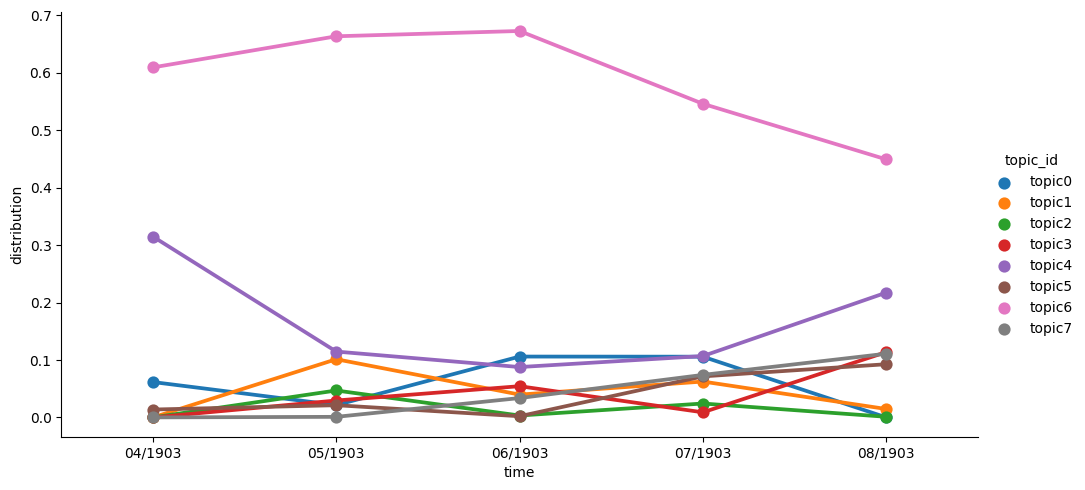

In [0]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


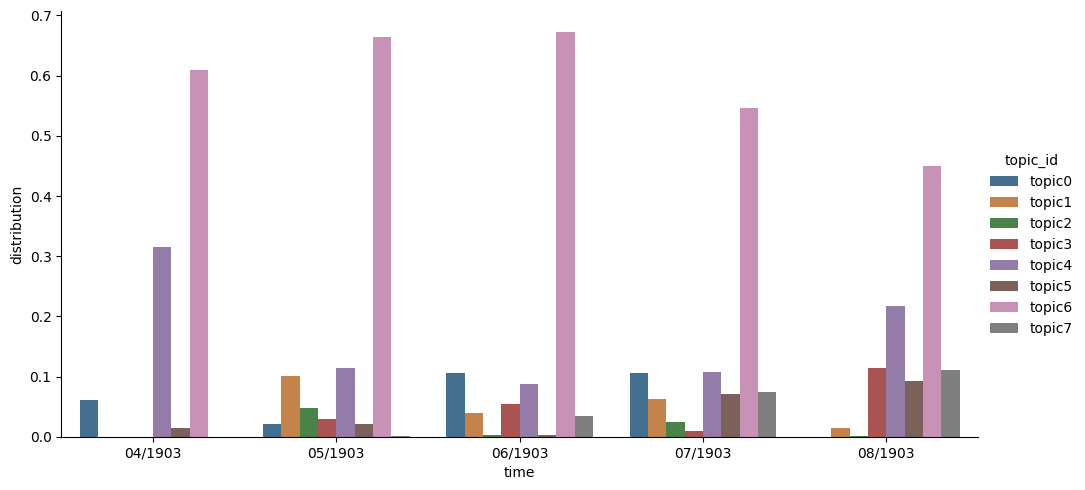

In [0]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.4 Normalized proportions of topic weights per title

In [0]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

In [0]:
distribution_gensim_wfiles['publication'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_ref(x))

In [0]:
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,date,year,month,publication
document,,,,,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000078,0.000078,0.000078,0.000078,0.686621,0.000078,0.312908,0.000078,1903-04-27,1903,04,sn85066408
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.246286,0.000070,0.000070,0.000070,0.000070,0.054853,0.698513,0.000070,1903-04-28,1903,04,sn85066408
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.999351,0.000093,1903-04-29,1903,04,sn85066408
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.000100,0.000100,0.000100,0.000100,0.572631,0.000100,0.426770,0.000100,1903-04-30,1903,04,sn85066408
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000150,0.998949,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,1903-05-01,1903,05,sn85066408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.997977,1903-08-05,1903,08,sn85066408
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.000086,0.128302,0.000086,0.024126,0.810042,0.000086,0.037187,0.000086,1903-08-06,1903,08,sn85066408
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000076,0.002932,0.000076,0.000076,0.000076,0.000076,0.996610,0.000076,1903-08-07,1903,08,sn85066408


In [0]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [0]:
distribution_title = gensim_groupby2.groupby(['publication']).mean().reset_index()

In [0]:
distribution_title

,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,2012271201,0.135811,0.076555,0.004301,0.192851,0.104229,0.274647,0.061616,0.149990
1,sn85066408,0.065654,0.057036,0.022678,0.019691,0.123347,0.010852,0.669226,0.031514


In [0]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

In [0]:
df_vis2

,publication,topic_id,distribution
0,2012271201,topic0,0.135811
1,2012271201,topic1,0.0765551
2,2012271201,topic2,0.00430099
3,2012271201,topic3,0.192851
4,2012271201,topic4,0.104229
5,2012271201,topic5,0.274647
6,2012271201,topic6,0.0616159
7,2012271201,topic7,0.14999
8,sn85066408,topic0,0.0656542
9,sn85066408,topic1,0.0570359


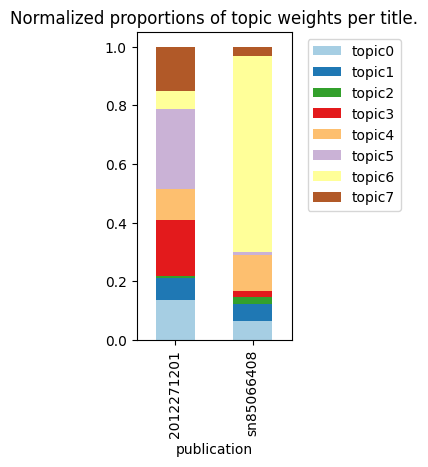

In [0]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time: Mallet